In [11]:
# Pseudobulk HVG selection (2-comp GMM)

import os, numpy as np, pandas as pd, scanpy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Paths (adjust)
H5AD_RAW   = "../../data/processed/breast_cancer_raw_annotated.h5ad"     # RAW counts with cells × genes
GENE_MAP   = "../../../../maps/gene_info.csv"                                   # columns: feature_id (Ensembl), feature_name (symbol)
SIDG_MAP   = "../../../../maps/gene_id_to_symbol_mapping.csv"                   # optional: columns: gene_id (SIDG...), symbol
BULK_PARQ  = "../../data/processed/voom_transformed_data.parquet"  # optional (for overlap)

OUTDIR = "hvg_analysis_outputs_pseudobulk"
os.makedirs(OUTDIR, exist_ok=True)

TOPK_SC = 3000          # mirror bulk (e.g., 3000)
EPS = 1e-12
RNG = 42


In [12]:
adata = sc.read_h5ad(H5AD_RAW)
print(adata)

AnnData object with n_obs × n_vars = 35276 × 47096
    var: 'gene_symbol'


In [13]:
# --- Add SANGER_MODEL_ID to adata.obs ---
import pandas as pd

# Load mapping table (CELL_LINE_NAME -> SANGER_MODEL_ID)
mapping_df = pd.read_csv("../../data/cell_sanger_map.csv").drop_duplicates()
mapping_df.columns = ['SANGER_MODEL_ID', 'CELL_LINE_NAME']

print("✅ Loaded mapping_df")
print("Mapping sample:")
print(mapping_df.head())

# Extract the cell line prefix from adata.obs.index (everything before the first underscore)
adata.obs['cell_line'] = adata.obs.index.str.split('_').str[0]

# Normalize names (remove dashes, uppercase)
adata.obs['cell_line_norm'] = (
    adata.obs['cell_line']
    .str.replace('-', '', regex=False)
    .str.upper()
)

mapping_df['CELL_LINE_NAME_NORM'] = (
    mapping_df['CELL_LINE_NAME']
    .str.replace('-', '', regex=False)
    .str.upper()
)

print("✅ Normalized cell line names in adata and mapping_df")

# Build mapping dict and map onto obs
name_to_sidm = dict(zip(mapping_df['CELL_LINE_NAME_NORM'], mapping_df['SANGER_MODEL_ID']))
adata.obs['SANGER_MODEL_ID'] = adata.obs['cell_line_norm'].map(name_to_sidm)

# Check mapping success
print("✅ Applied SIDM mapping")
print(adata.obs[['cell_line', 'cell_line_norm', 'SANGER_MODEL_ID']].drop_duplicates().head(10))

# Report unmapped
unmapped = adata.obs[adata.obs['SANGER_MODEL_ID'].isna()]['cell_line'].unique()
print("❗ Unmapped cell lines:", unmapped)
print("Total unmapped:", len(unmapped))

# Drop unmapped if needed
adata = adata[~adata.obs['SANGER_MODEL_ID'].isna()].copy()
print("✅ Filtered adata to only include mapped cell lines")
print("Remaining shape:", adata.shape)


✅ Loaded mapping_df
Mapping sample:
  SANGER_MODEL_ID CELL_LINE_NAME
0       SIDM00853            GCT
1       SIDM00567         ONS-76
2       SIDM00042            PL4
3       SIDM00455     PA-TU-8902
4       SIDM00881        HCC1428
✅ Normalized cell line names in adata and mapping_df
✅ Applied SIDM mapping
                      cell_line cell_line_norm SANGER_MODEL_ID
AU565_AAACCAGTTTGG        AU565          AU565       SIDM00898
HCC1937_AAAACAACTGTT    HCC1937        HCC1937       SIDM00874
HCC38_AAAAGGCTGCGC        HCC38          HCC38       SIDM00675
MDAMB468_AAAAACATCCGA  MDAMB468       MDAMB468       SIDM00628
EFM19_AAAATAATTCGG        EFM19          EFM19       SIDM01056
HCC1187_AAAATGCGAAAC    HCC1187        HCC1187       SIDM00885
JIMT1_AAAAATGGCCAG        JIMT1          JIMT1       SIDM01037
MDAMB361_AAAATGTCCCAG  MDAMB361       MDAMB361       SIDM00528
HCC1500_AAAATCAGGACC    HCC1500        HCC1500       SIDM00879
HCC70_AAAAGACTATAG        HCC70          HCC70       SIDM006

In [14]:
print("obs columns:", adata.obs.columns.tolist())
print(adata.obs.head())

# We need a grouping key per pseudo-bulk sample.
# Preferred: obs['SANGER_MODEL_ID']. If you use another field, change here.
group_col = "SANGER_MODEL_ID"
assert group_col in adata.obs.columns, f"'{group_col}' not found in adata.obs"

X = adata.X.tocsr() if not sp.isspmatrix_csr(adata.X) else adata.X
groups = adata.obs[group_col].astype(str).values
uniq_groups = pd.Index(groups).unique().tolist()
print("Unique pseudo-bulk samples:", len(uniq_groups))


obs columns: ['cell_line', 'cell_line_norm', 'SANGER_MODEL_ID']
                   cell_line cell_line_norm SANGER_MODEL_ID
AU565_AAACCAGTTTGG     AU565          AU565       SIDM00898
AU565_AAACGTGCAGCG     AU565          AU565       SIDM00898
AU565_AAAGCCACATGC     AU565          AU565       SIDM00898
AU565_AAAGTCGGCTGG     AU565          AU565       SIDM00898
AU565_AAAGTGCCTAAA     AU565          AU565       SIDM00898
Unique pseudo-bulk samples: 28


In [17]:
# Ensembl IDs without version
ens = pd.Index(adata.var_names.astype(str)).str.split(".").str[0]

# Load mapping Ensembl -> symbol
gmap = pd.read_csv(GENE_MAP)
gmap["ensembl_novers"] = gmap["feature_id"].astype(str).str.split(".").str[0]
gmap["symbol"] = gmap["feature_name"].astype(str)
ens2sym = dict(zip(gmap["ensembl_novers"], gmap["symbol"]))

# Convert ens to Series so we can fillna with it
ens_series = pd.Series(ens, index=ens)

# Map to symbols, fallback to original ENS IDs
sym = ens_series.map(ens2sym).fillna(ens_series).astype(str)

# Optionally convert back to Index
sym = pd.Index(sym)


In [19]:
rows = []
for sid in uniq_groups:
    idx = np.where(groups == sid)[0]
    row = X[idx, :].sum(axis=0)       # could be ndarray or matrix
    row = sp.csr_matrix(row)          # ensure it's 2D sparse
    rows.append(row)

pb_counts = sp.vstack(rows).tocsr().toarray()  # (#groups × #genes)
pb = pd.DataFrame(pb_counts, index=uniq_groups, columns=sym)
print("Pseudo-bulk counts shape:", pb.shape)


Pseudo-bulk counts shape: (28, 47096)


In [20]:
# Library-size normalize and log-transform
lib = pb.sum(axis=1).replace(0, np.nan)
pb_cpm   = (pb.div(lib, axis=0) * 1e6).fillna(0.0)
pb_log1p = np.log1p(pb_cpm)

print("Pseudo-bulk log1p CPM shape:", pb_log1p.shape)
pb_log1p.to_parquet(os.path.join(OUTDIR, "sc_pseudobulk_log1pCPM.parquet"))


Pseudo-bulk log1p CPM shape: (28, 47096)


In [21]:
# SD per gene across pseudo-bulk samples
sd = pb_log1p.std(axis=0)
print(sd.describe())

# GMM on log10(SD)
logsd = np.log10(sd.values + EPS).reshape(-1, 1)
gmm = GaussianMixture(n_components=2, random_state=RNG).fit(logsd)

means   = gmm.means_.flatten()
weights = gmm.weights_.flatten()
vars_   = gmm.covariances_.reshape(-1)

hi_comp = int(np.argmax(means))
assign  = gmm.predict(logsd)
cands   = sd.index[assign == hi_comp]

print("GMM means (log10 SD):", means, "| weights:", weights)
print("High-variance candidates:", len(cands))


count    47096.000000
mean         0.339513
std          0.358981
min          0.000000
25%          0.053775
50%          0.220252
75%          0.512045
max          3.421836
dtype: float64
GMM means (log10 SD): [ -0.77172602 -12.        ] | weights: [0.99069985 0.00930015]
High-variance candidates: 46658


In [25]:
# SD across pseudo-bulk samples
sd = pb_log1p.std(axis=0)

# Drop zero-variance genes from the log/GMM step
n_zero = int((sd == 0).sum())
sd_pos = sd[sd > 0]
print(f"Genes with SD=0 (excluded from GMM): {n_zero} / {len(sd)}")

# Log10(SD) only for positive SD
logsd = np.log10(sd_pos.values).reshape(-1, 1)

# 2-component GMM on log10(SD)
gmm = GaussianMixture(n_components=2, random_state=42).fit(logsd)
means   = gmm.means_.flatten()
weights = gmm.weights_.flatten()
hi_comp = int(np.argmax(means))

# Assign only the positive-SD genes, then map back to the full index
assign_pos = pd.Series(gmm.predict(logsd), index=sd_pos.index)
assign_all = pd.Series(-1, index=sd.index)               # -1 for zero-SD genes
assign_all.loc[assign_pos.index] = assign_pos.values

# Candidates = genes in the high-variance component among SD>0
cands = sd.index[assign_all == hi_comp]
print("GMM means (log10 SD):", means, "| weights:", weights)
print("High-variance candidates:", len(cands))

# Select top-K within that component
TOPK_SC = 3000
hvg_sc = sd.loc[cands].sort_values(ascending=False).head(TOPK_SC).index.tolist()
print(f"Selected HVGs (top-{TOPK_SC}):", len(hvg_sc))


Genes with SD=0 (excluded from GMM): 438 / 47096
GMM means (log10 SD): [-1.30870682 -0.31269411] | weights: [0.46086953 0.53913047]
High-variance candidates: 25388
Selected HVGs (top-3000): 3000


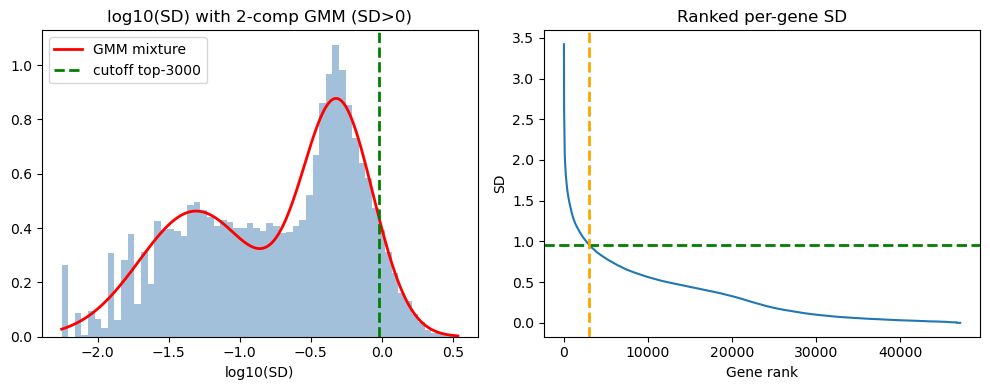

In [26]:
# Histogram uses log10(SD) of positive-SD genes only
fig, ax = plt.subplots(1, 2, figsize=(10,4))

# Left: histogram + mixture + cutoff
xs = np.linspace(logsd.min(), logsd.max(), 512).reshape(-1,1)
mix_pdf = np.exp(gmm.score_samples(xs))
ax[0].hist(logsd.ravel(), bins=60, density=True, alpha=0.5, color="steelblue")
ax[0].plot(xs, mix_pdf, 'r-', lw=2, label="GMM mixture")
sd_cut = sd.loc[hvg_sc].min()
ax[0].axvline(np.log10(sd_cut), color="green", ls="--", lw=2, label=f"cutoff top-{TOPK_SC}")
ax[0].set_xlabel("log10(SD)")
ax[0].set_title("log10(SD) with 2-comp GMM (SD>0)")
ax[0].legend()

# Right: ranked SD with cut lines (all genes; SD is non-negative)
sd_sorted = sd.sort_values(ascending=False).values
ax[1].plot(np.arange(1, len(sd_sorted)+1), sd_sorted)
ax[1].axhline(sd_cut, color="green", ls="--", lw=2)
ax[1].axvline(len(hvg_sc), color="orange", ls="--", lw=2)
ax[1].set_xlabel("Gene rank"); ax[1].set_ylabel("SD"); ax[1].set_title("Ranked per-gene SD")
plt.tight_layout(); plt.show()


In [27]:
# Only if your bulk genes are in SIDG namespace and you want the overlap list now
if os.path.exists(SIDG_MAP) and os.path.exists(BULK_PARQ):
    sidg_map = pd.read_csv(SIDG_MAP)
    sym2sidg = dict(zip(sidg_map["symbol"].astype(str), sidg_map["gene_id"].astype(str)))
    sc_hvg_sidg = pd.Series(hvg_sc).map(sym2sidg).dropna().unique().tolist()
    print("sc HVGs mapped to SIDG:", len(sc_hvg_sidg))

    bulk = pd.read_parquet(BULK_PARQ)
    bulk_genes = set(bulk.columns.astype(str))
    overlap_sidg = sorted(set(sc_hvg_sidg) & bulk_genes)
    print("Overlap (SIDG) with bulk:", len(overlap_sidg))

    pd.Series(overlap_sidg, name="SIDG").to_csv(
        os.path.join(OUTDIR, f"HVG_overlap_bulk__sc_pseudobulk_top{TOPK_SC}.csv"),
        index=False
    )


sc HVGs mapped to SIDG: 2760
Overlap (SIDG) with bulk: 2760
